# NYC Taxi Trip Duration Prediction

*Author: [Michael Karpe](https://www.kaggle.com/mika30)* <br>

[Kaggle InClass Competition](https://www.kaggle.com/c/ieor242hw4) for UC Berkeley *IEOR 242 Applications in Data Analysis* course. Given NYC taxi trips information, we want to predict their travel duration in seconds. More information about the data on the [NYC TLC website](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Root Mean Square Error (RMSE) is used for evaluation. <br>

*Public Score: 258.47466 (#1). Private Score: 253.84098 (#1).*

**If you find this kernel useful, show your interest in the work done by upvoting the kernel!**

# Contents

1. [Preliminary Study](#PreliminaryStudy) <br>
    1.1. [Data Loading](#DataLoading) <br>
    1.2. [Missing Values](#MissingValues)<br>
    1.3. [Data Preprocessing](#DataPreprocessing)<br>
    1.4. [Exploratory Data Analysis (EDA)](#ExploratoryDataAnalysisEDA)<br>
2. [Outlier Analysis](#OutlierAnalysis) <br>
    2.1. [Outlier Detection](#OutlierDetection) <br>
    2.2. [Outlier Correction](#OutlierCorrection)<br>
    2.3. [Outlier Removal](#OutlierRemoval)<br>
3. [Further Processing](#FurtherProcessing) <br>
    3.1. [Target Transformation](#TargetTransformation) <br>
    3.2. [Feature Engineering](#FeatureEngineering)<br>
    3.3. [Zone Encoding](#ZoneEncoding)<br>
    3.4. [Data Downcasting](#DataDowncasting)<br>
    3.5. [Feature Correlations](#FeatureCorrelations)<br>
4. [Modeling](#Modeling) <br>
    4.1. [Data Splitting](#DataSplitting) <br>
    4.2. [Regressors](#Regressors)<br>
    4.3. [Validation](#Validation)<br>
    4.4. [Feature Importances](#FeatureImportances)<br>
5. [Prediction](#Prediction)<br>

In [1]:
from datetime import date
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
sns.set()

seed = 42

# 1. Preliminary Study

## 1.1. Data Loading

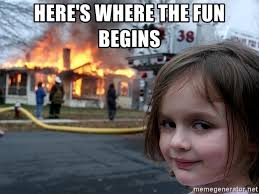 <br>

Let's load data and display a sample of train and test sets.

In [2]:
PATH_TO_DATA = "/kaggle/input/ieor242hw4"
train = pd.read_csv(PATH_TO_DATA + "/train.csv", parse_dates=["pickup_datetime"])
test = pd.read_csv(PATH_TO_DATA + "/test.csv", parse_dates=["pickup_datetime"])
sub = pd.read_csv(PATH_TO_DATA + "/submission.csv")

print("Train sample:")
display(train.sample(5))
print("Test sample:")
display(test.sample(5))

Train sample:


row_id  VendorID     pickup_datetime  passenger_count  trip_distance  \
133851  133851       2.0 2019-02-24 17:49:44              1.0           0.93   
57451    57451       1.0 2016-10-12 09:39:47              1.0           0.50   
53128    53128       1.0 2019-01-03 08:34:45              1.0           0.80   
47128    47128       1.0 2016-10-20 11:53:18              1.0          11.20   
9902      9902       2.0 2019-01-25 17:51:52              1.0          16.85   

       pickup_borough       pickup_zone dropoff_borough  \
133851      Manhattan     Midtown North       Manhattan   
57451       Manhattan      Central Park       Manhattan   
53128       Manhattan          Flatiron       Manhattan   
47128       Manhattan  Garment District          Queens   
9902           Queens       JFK Airport       Manhattan   

                     dropoff_zone  duration  
133851  Times Sq/Theatre District       351  
57451                Central Park       223  
53128                 Murray Hill       439  
47128           LaGuardia Airport      1877  
9902          UN/Turtle Bay South      2356

Test sample:


row_id  VendorID     pickup_datetime  passenger_count  trip_distance  \
1957     1957       1.0 2019-02-03 01:27:13              1.0           2.40   
61558   61558       2.0 2019-02-21 07:17:13              1.0           2.04   
24180   24180       2.0 2019-02-08 18:02:49              1.0           1.52   
1399     1399       2.0 2016-10-10 21:39:37              2.0           9.73   
67219   67219       2.0 2019-02-08 06:39:52              1.0           8.63   

      pickup_borough                    pickup_zone dropoff_borough  \
1957       Manhattan  Meatpacking/West Village West       Manhattan   
61558      Manhattan          Upper West Side South       Manhattan   
24180      Manhattan                   Central Park       Manhattan   
1399          Queens              LaGuardia Airport          Queens   
67219      Manhattan            UN/Turtle Bay South          Queens   

                dropoff_zone  
1957                 Seaport  
61558  Upper East Side North  
24180  Upper East Side North  
1399         Oakland Gardens  
67219      LaGuardia Airport

For sake of simplicity, we use lookup tables on the [NYC TLC website](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) for label encoding of pickup and dropoff boroughs and zones. A simple label encoder can be used instead if lookup tables are not available.

In [3]:
PATH_TO_LOOKUP = "/kaggle/input/nyc-yellow-taxi-zone-lookup-table"
lookup = pd.read_csv(PATH_TO_LOOKUP + "/taxi_zone_lookup.csv")

loc_to_borough = dict(zip(lookup["LocationID"], lookup["Borough"].apply(lambda x: str(x).lower())))
loc_to_zone = dict(zip(lookup["LocationID"], lookup["Zone"].apply(lambda x: str(x).lower())))

zone_to_loc = {value: key for key, value in loc_to_zone.items()}
zone_to_loc["unknown"] = 265

borough_to_label = {'Bronx': 1, 'Brooklyn': 2, 'EWR': 3, 'Manhattan': 4, 'Queens': 5, 'Staten Island': 6, 'Unknown': 7}
borough_to_label = {key.lower(): value for key, value in borough_to_label.items()}

## 1.2. Missing Values

Let's evaluate the ratio of missing values for each column of our train set.

In [4]:
train.isnull().mean()

row_id             0.000000
VendorID           0.002036
pickup_datetime    0.001361
passenger_count    0.002036
trip_distance      0.000000
pickup_borough     0.000000
pickup_zone        0.000636
dropoff_borough    0.000000
dropoff_zone       0.002661
duration           0.000000
dtype: float64

Very few values are missing (at most 0.27% of values for `dropoff_zone`). We notice that the ratio of missing values is the same for `VendorID` and `passenger_count`. Let's check that `VendorID` is missing if and only if `passenger_count` is missing.

In [5]:
train[
    train["VendorID"].isnull() |
    train["passenger_count"].isnull()
][["VendorID", "passenger_count"]].isnull().mean()

VendorID           1.0
passenger_count    1.0
dtype: float64

Let's check the ratio of missing values for each column of our test set is approximately the same as in the train set.

In [6]:
test.isnull().mean()

row_id             0.000000
VendorID           0.002015
pickup_datetime    0.001499
passenger_count    0.002015
trip_distance      0.000000
pickup_borough     0.000000
pickup_zone        0.000554
dropoff_borough    0.000000
dropoff_zone       0.002519
dtype: float64

## 1.3. Data Preprocessing

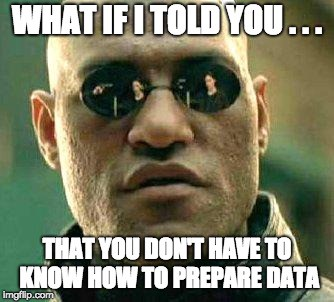 <br>

Let's perform some preprocessing of the data in order to perform the EDA. It includes filling missing values with a special value, label encoding of boroughs and zones and extracting valuable information from the pickup date.

In [7]:
out_val = 999

def preprocess_data(data):
    # VendorID and passenger count
    data["VendorID"] = data["VendorID"].replace({np.nan: 0}).apply(int)
    data["passenger_count"] = data["passenger_count"].replace({np.nan: 0}).apply(int)

    # Pickup and dropoff boroughs and zones
    data["pickup_borough"] = data["pickup_borough"].apply(lambda x: borough_to_label[x.lower()])
    data["dropoff_borough"] = data["dropoff_borough"].apply(lambda x: borough_to_label[x.lower()])
    data["pickup_zone"] = data["pickup_zone"].replace({np.nan: "Unknown"}).apply(lambda x: zone_to_loc[x.lower()])
    data["dropoff_zone"] = data["dropoff_zone"].replace({np.nan: "Unknown"}).apply(lambda x: zone_to_loc[x.lower()])

    # Pickup datetime
    data["pickup_datetime"] = data["pickup_datetime"].replace({np.nan: out_val})
    data["pickup_year"] = data["pickup_datetime"].apply(lambda x: int(x.year) if x != out_val else out_val)
    data["pickup_month"] = data["pickup_datetime"].apply(lambda x: int(x.month) if x != out_val else out_val)
    data["pickup_day"] = data["pickup_datetime"].apply(lambda x: int(x.day) if x != out_val else out_val)
    data["pickup_hour"] = data["pickup_datetime"].apply(lambda x: x.hour if x != out_val else out_val)
    data["pickup_minute"] = data["pickup_datetime"].apply(lambda x: x.minute if x != out_val else out_val)
   
    # Further extraction: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html
    data["pickup_dayofweek"] = data["pickup_datetime"].apply(lambda x: int(x.dayofweek) if x != out_val else out_val)
    data["pickup_dayofyear"] = data["pickup_datetime"].apply(lambda x: int(x.dayofyear) if x != out_val else out_val)
    # data["pickup_weekofyear"] = data["pickup_datetime"].apply(lambda x: int(x.weekofyear) if x != out_val else out_val)
    
    # Drop useless columns
    data = data.drop(columns=["row_id"])
    
    return data.reset_index(drop=True)


train = preprocess_data(train)
test = preprocess_data(test)

## 1.4. Exploratory Data Analysis (EDA)

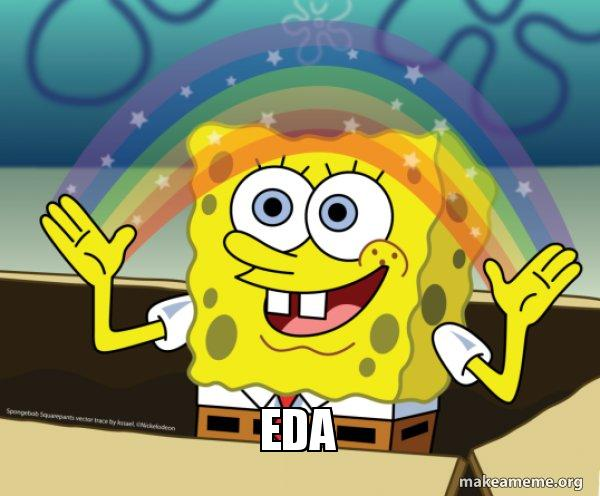 <br>

Here, we display the distribution of the data for each column of train and test sets.

Train EDA:


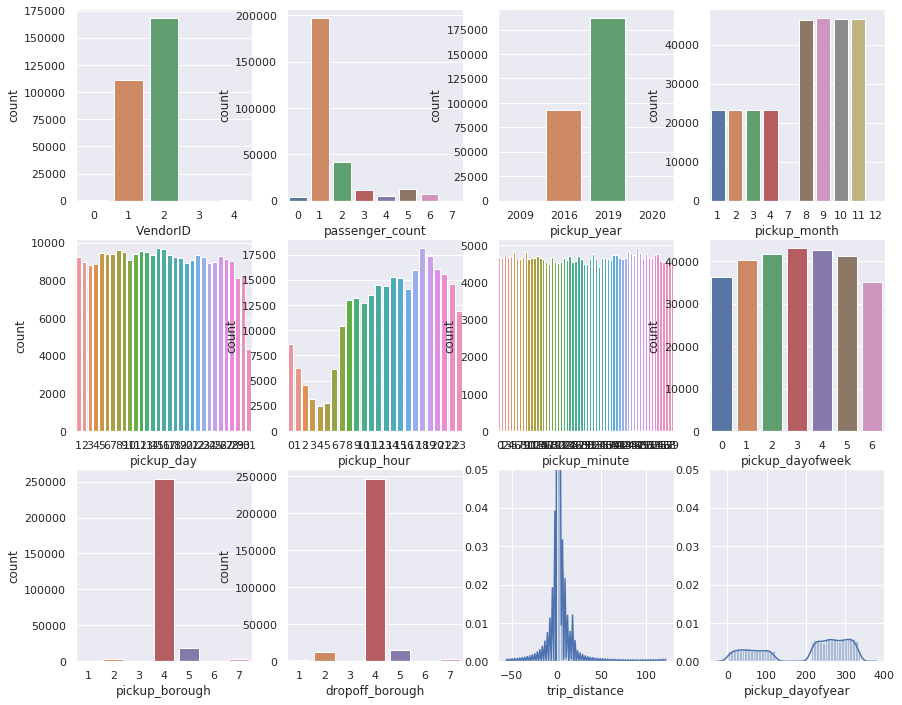

Test EDA:


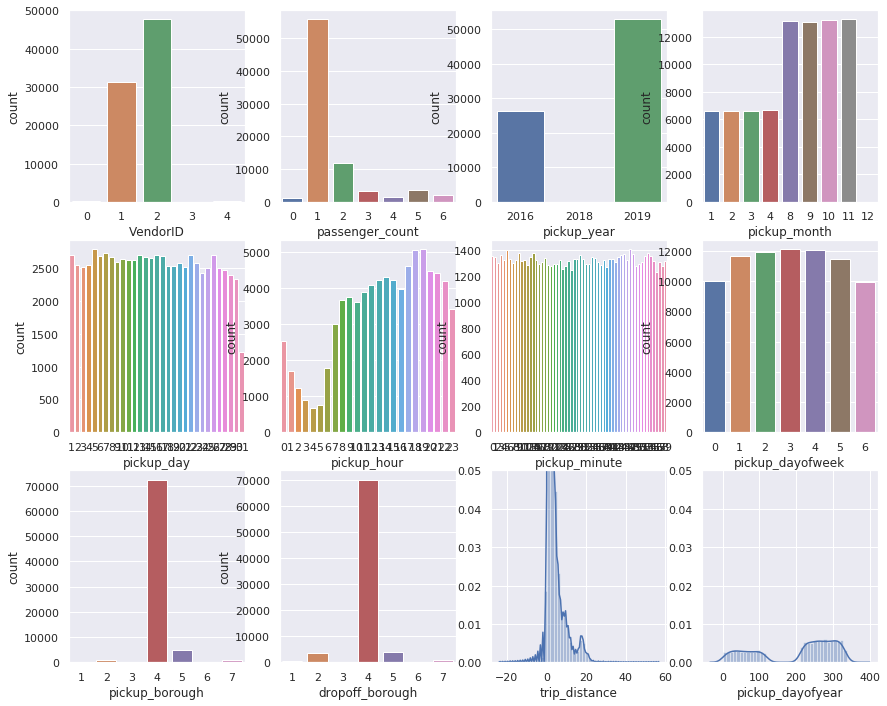

In [8]:
categorical_columns = [
    "VendorID", "passenger_count", "pickup_year", "pickup_month", "pickup_day", "pickup_hour", "pickup_minute",
    "pickup_dayofweek", "pickup_borough", "dropoff_borough"
]
numerical_columns = ["trip_distance", "pickup_dayofyear"]


def display_data(data):
    nb_rows, nb_cols = max((len(categorical_columns + numerical_columns) - 3) // 4 + 1, 2), 4
    fig, ax = plt.subplots(figsize=(14.5, 4 * nb_rows), nrows=nb_rows, ncols=nb_cols)
    for ind, column in enumerate(categorical_columns + numerical_columns):
        if column in categorical_columns:
            sns.countplot(data[data[column] != out_val][column], ax=ax[ind // nb_cols, ind % nb_cols])
        elif column in numerical_columns:
            sns.distplot(data[data[column] != out_val][column], ax=ax[ind // nb_cols, ind % nb_cols])
            ax[ind // nb_cols, ind % nb_cols].set_ylim((0, 0.05))

    plt.show()


print("Train EDA:")
display_data(train)
print("Test EDA:")
display_data(test)

We can notice first that distributions of train and test sets look to be the same. We can also take note of the following observations:
- `VendorID` and `passenger_count` values are mainly 1 or 2.
- After further observation of `pickup_year` and `pickup_month`, we can see that the data is divided into 3 sets of approximately equal size: trips between 08/2016 and 11/2016, between 01/2019 and 04/2019 and between 08/2019 and 11/2019.
- Distribution of `pickup_day`, `pickup_minute` and is roughly uniform. Given the previous observation, `pickup_dayofyear` is also uniform.
- There are less trips on Mondays (0) and Sundays (6) than on other days. There is a clear relation between the day of the week and the number of trips.
- There is an even clearer relation between the number of trips performed and the hour of the day. The hours with the most trips are 6pm and 7pm, the hours with the fewest trips are 4am and 5am. *This feature will probably be one of the most important features, as we may consider that trips are longer if there is more traffic.*
- Pickup and dropoff boroughs are mostly 4 (Manhattan), followed by 5 (Queens) and 2 (Brooklyn).
- Some `trip_distance` are negative (and will be studied in the *Outlier Analysis* section). Otherwise, after further observation, the distribution looks to be lognormal.

Categorical features with only few unique values are going to be handled well by gradient boosted trees regressors. Our goal being to predict the duration of a trip, the most promising features (and which also have a high variance) are `trip_distance`, `pickup_hour` and `pickup_dayofweek`.


# 2. Outlier Analysis

## 2.1. Outlier Detection

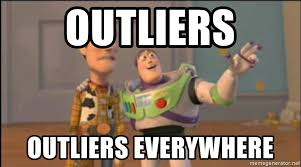 <br>

Here, we try to understand the presence of negative values for `trip_distance`. As this feature is probably the one that most explains the `duration` we want to predict, we will plot the `duration` of a trip against `trip_distance`.

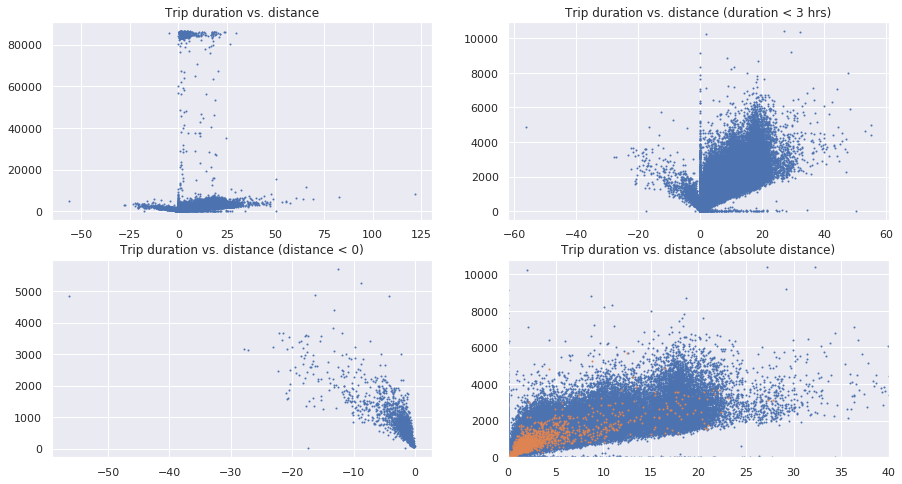

In [9]:
fig, ax = plt.subplots(figsize=(15, 4 * 2), nrows=2, ncols=2)

ax[0, 0].scatter(train["trip_distance"], train["duration"], s=1)
ax[0, 0].set_title("Trip duration vs. distance")
max_duration = 3600 * 3
# Some outlier removal performed here, be careful
train = train[(train["duration"] <= max_duration) & (train["trip_distance"] <= test["trip_distance"].max())]
ax[0, 1].scatter(train["trip_distance"], train["duration"], s=1)
ax[0, 1].set_title("Trip duration vs. distance (duration < 3 hrs)")

negative_dist = train[(train["trip_distance"] < 0)]
ax[1, 0].scatter(negative_dist["trip_distance"], negative_dist["duration"], s=1)
ax[1, 0].set_title("Trip duration vs. distance (distance < 0)")

positive_dist = train[(train["trip_distance"] >= 0)]
ax[1, 1].scatter(positive_dist["trip_distance"], positive_dist["duration"], s=1)
ax[1, 1].scatter(negative_dist["trip_distance"].apply(abs), negative_dist["duration"], s=1)
ax[1, 1].set_xlim(0, 40)
ax[1, 1].set_ylim(0, max_duration)
ax[1, 1].set_title("Trip duration vs. distance (absolute distance)")

plt.show()

On the upper left graph, we plot trip duration against distance without any transformation performed on the train data. We observe again the presence of negative trip distances, as well as a cluster of dots corresponding to trips of short distance that would have been performed in around 24 hours. These trips are surely outliers, probably as well as most of the trips lasting several hours for a short distance.

We remove trips lasting more than 3 hours on the upper right graph. We can better see the distribution of the majority of the data, and note that there are not only negative trip distances but also distances and durations being equal to 0. Trips with a distance or duration equal to 0 will are of course outliers.

On the bottom left, we observe the distribution of trips with negative distance. We notice a symmetry with trips having a positive distance.

After taking the absolute value of the trip distance as the real trip distance, we can see with the orange points that trips with a negative distance fit perfectly with the data distribution when this distance to be considered positive. We may thus *correct* trip distance values by taking the absolute value.

Finally, we observe very few points corresponding to trips with either a very high or a very low speed. We may also want to remove these trips from the training set with some manual removal as shown below.

In [10]:
fig = px.scatter(
    x=train["trip_distance"], y=train["duration"], range_x=[0, 40], range_y=[0, 3600 * 2]
)
fig.update_traces(marker=dict(size=3))
fig.show()

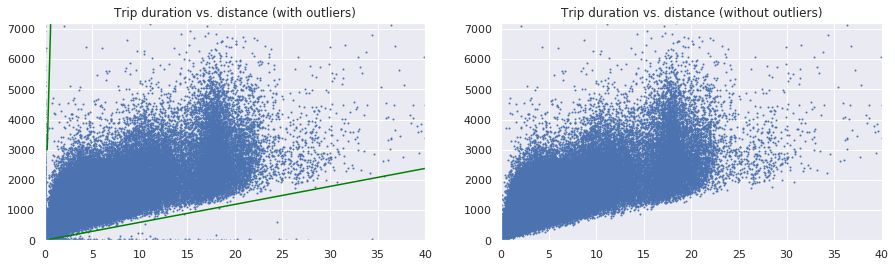

In [11]:
fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)
ax[0].scatter(train["trip_distance"], train["duration"], s=1)
slow_distance, slow_duration = 2.61, 29828
fast_distance, fast_duration = 35.7, 2124
ax[0].plot(
    [0.5, 0.5, fast_distance, 125],
    [0, 0.5 * fast_duration / fast_distance, fast_duration, 125 * fast_duration / fast_distance],
    color="green"
)
ax[0].plot(
    [0, slow_distance * 3000 / slow_duration, slow_distance * 2, slow_distance * 86400 / slow_duration],
    [3000, 3000, slow_duration * 2, 86400],
    color="green"
)
ax[0].set_xlim(0, 40)
ax[0].set_ylim(0, 3600 * 2)
ax[0].set_title("Trip duration vs. distance (with outliers)")

outliers = (
    (train["trip_distance"] == 0) |
    (train["duration"] == 0) |
    (train["trip_distance"] / train["duration"] >= fast_distance / fast_duration) & (train["trip_distance"] >= 0.5) |
    (train["trip_distance"] / train["duration"] <= slow_distance / slow_duration) & (train["duration"] >= 3000)
)
ax[1].scatter(train[~outliers]["trip_distance"], train[~outliers]["duration"], s=1)
ax[1].set_xlim(0, 40)
ax[1].set_ylim(0, 3600 * 2)
ax[1].set_title("Trip duration vs. distance (without outliers)")

plt.show()

## 2.2. Outlier Correction

Given the previous outlier analysis, we apply here the absolute value to the trip distance column on train and test sets.

In [12]:
def correct_outliers(data):
    data["trip_distance"] = data["trip_distance"].apply(abs)
    
    return data.reset_index(drop=True)


train = correct_outliers(train)
test = correct_outliers(test)

## 2.3. Outlier Removal

Again, given the previous outlier analysis, we remove here trips lasting more than 3 hours, as well as trips having a distance equal to 0, or a duration equal to 0, or a very high speed, or a very low speed.

Of course, we remove outliers only on the train set as we still need to predict duration of outliers on the test set.

In [13]:
def remove_outliers(data):
    data = data[(data["duration"] <= max_duration)]  # Already removed before, be careful
    outliers = (
        (data["trip_distance"] == 0) |
        (data["duration"] == 0) |
        (data["trip_distance"] / data["duration"] >= fast_distance / fast_duration) & (data["trip_distance"] >= 0.5) |
        (data["trip_distance"] / data["duration"] <= slow_distance / slow_duration) & (data["duration"] >= 3000)
    )
    data = data[~outliers]

    return data.reset_index(drop=True)


train = remove_outliers(train)

# 3. Further Processing

## 3.1. Target Transformation

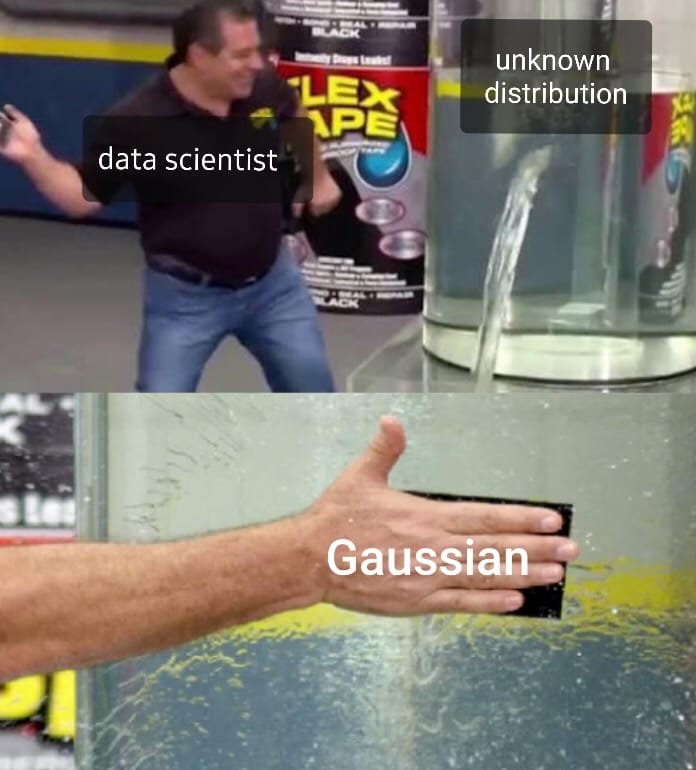 <br>

When plotting the distribution of trips `duration`, we can see that the distribution is also lognormal. Therefore, as we removed trips with a duration equal to 0 in the previous section, we may want to fit our regressors of the log transformation of the target, in order the reduce a bias of the classifier that could be due to very high trip durations.

*N.B.:* We perform target transformation only in the `fit` of the regressors in order not to forget to perform the inverse transformation when doing the `predict`.

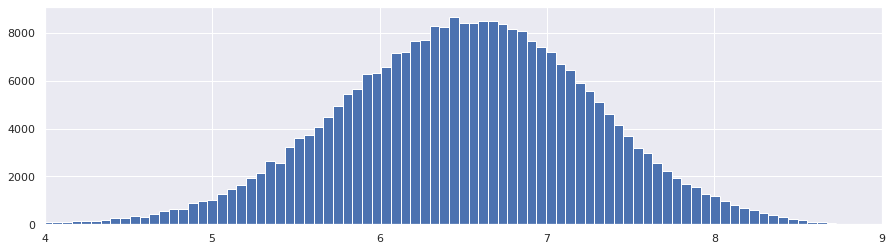

In [14]:
plt.figure(figsize=(15, 4))
train["duration"].apply(np.log).hist(bins=160)
plt.xlim(4, 9)
plt.show()

## 3.2. Feature Engineering

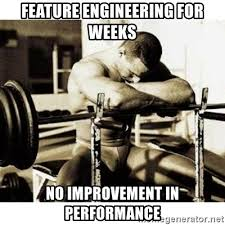 <br>

As explained in the EDA, we observed a clear relationship between the hour of the day and the number of trips. We also explained that probably the more trips on a given hour, the higher the duration of a trip starting at this hour. However, we may think that this correlation can also be observed on a time period shorter than 1 hour; for example, 30 minutes, 20 minutes, 15 minutes or 10 minutes.

Therefore, we may create a feature similar to the `pickup_hour` feature for such a smaller time range. After trying the time ranges mentioned before, we found that the one giving the best result is 15 minutes. We thus create a feature corresponding to the quarter of an hour when the trip started.

Also, we note that after having created such a feature, the year, month, day, hour and minute features are no longer really useful for our future models. As a result, we also remove these features in the feature engineering function below.

In [15]:
def feature_engineering(data):
    data["pickup_quarterhour"] = data["pickup_datetime"].apply(
        lambda x: (x - pd.Timestamp(int(x.year), 1, 1)).seconds // (60 * 15) if x != out_val else out_val
    )
    data = data.drop(columns=[
        "pickup_datetime", "pickup_year", "pickup_month", "pickup_day", "pickup_hour", "pickup_minute"
    ])
    
    return data.reset_index(drop=True)


train = feature_engineering(train)
test = feature_engineering(test)

## 3.3. Zone Encoding

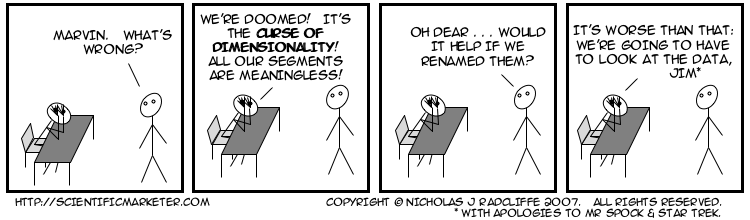 <br>

For dealing with categorical features in such problems, we usually perform label or one-hot encoding. If it is reasonable to perform one-hot encoding with boroughs (as we only have 7 unique boroughs), it is not for zones as we have around 265 unique zones. However, label encoding for zones would not be a solution either as labels would not be ordered and our gradient boosted trees methods would have to perform almost as many splits as values for this feature.

We thus perform a mix between label and one-hot encoding, performing the one-hot encoding of boroughs, and then assigning the zone value in the corresponding column.

For example, if a trip started in the borough 3 and zone 54, `pickup_borough_3` will be assigned the value 54 (instead of 1 for classical one-hot encoding) and other `pickup_borough_i` columns will be assigned the value 0 for $i$ not equal to 3.

Such a transformation has the benefit for the training data to have both few features and few values for each feature.

In [16]:
def one_hot_encoding(data):
    for i in range(1, 8):
        data["pickup_borough_{}".format(i)] = data["pickup_zone"].apply(
            lambda x: x if borough_to_label[loc_to_borough[x]] == i else 0
        )
        data["dropoff_borough_{}".format(i)] = data["dropoff_zone"].apply(
            lambda x: x if borough_to_label[loc_to_borough[x]] == i else 0
        )

    data = data.drop(columns=["pickup_zone", "dropoff_zone", "pickup_borough", "dropoff_borough"])
    
    return data


train = one_hot_encoding(train)
test = one_hot_encoding(test)

train.shape

(276900, 21)

## 3.4. Data Downcasting

When some values are not `float` values requiring the maximum precision, we may want to downcast the data, mainly for memory issues. For example, `VendorID` may be considered as an `int` column and not as a `float` column, as it is done initially when loading the data because there were some missing values.

In our data, the only "real" `float` data is `trip_distance`, however we observe that the precision of `trip_distance` is to the hundredth. Therefore, we can multiply `trip_distance` by 100 and also consider `trip_distance` as an `int`.

In [17]:
(train >= 0).mean()

VendorID              1.0
passenger_count       1.0
trip_distance         1.0
duration              1.0
pickup_dayofweek      1.0
pickup_dayofyear      1.0
pickup_quarterhour    1.0
pickup_borough_1      1.0
dropoff_borough_1     1.0
pickup_borough_2      1.0
dropoff_borough_2     1.0
pickup_borough_3      1.0
dropoff_borough_3     1.0
pickup_borough_4      1.0
dropoff_borough_4     1.0
pickup_borough_5      1.0
dropoff_borough_5     1.0
pickup_borough_6      1.0
dropoff_borough_6     1.0
pickup_borough_7      1.0
dropoff_borough_7     1.0
dtype: float64

In [18]:
def downcast_data(data):
    data["trip_distance"] = (100 * data["trip_distance"]).astype(int)

    for column in data.columns:
        data[column] = pd.to_numeric(data[column], downcast='unsigned')
    
    return data.reset_index(drop=True)


train = downcast_data(train)
test = downcast_data(test)

train.dtypes

VendorID               uint8
passenger_count        uint8
trip_distance         uint16
duration              uint16
pickup_dayofweek      uint16
pickup_dayofyear      uint16
pickup_quarterhour    uint16
pickup_borough_1      uint16
dropoff_borough_1     uint16
pickup_borough_2      uint16
dropoff_borough_2     uint16
pickup_borough_3       uint8
dropoff_borough_3      uint8
pickup_borough_4      uint16
dropoff_borough_4     uint16
pickup_borough_5      uint16
dropoff_borough_5     uint16
pickup_borough_6       uint8
dropoff_borough_6      uint8
pickup_borough_7      uint16
dropoff_borough_7     uint16
dtype: object

## 3.5. Feature Correlations

Data downcasting is also useful for accurate computations of correlations. We display the correlation matrix of our train data after all the transformations performed before.

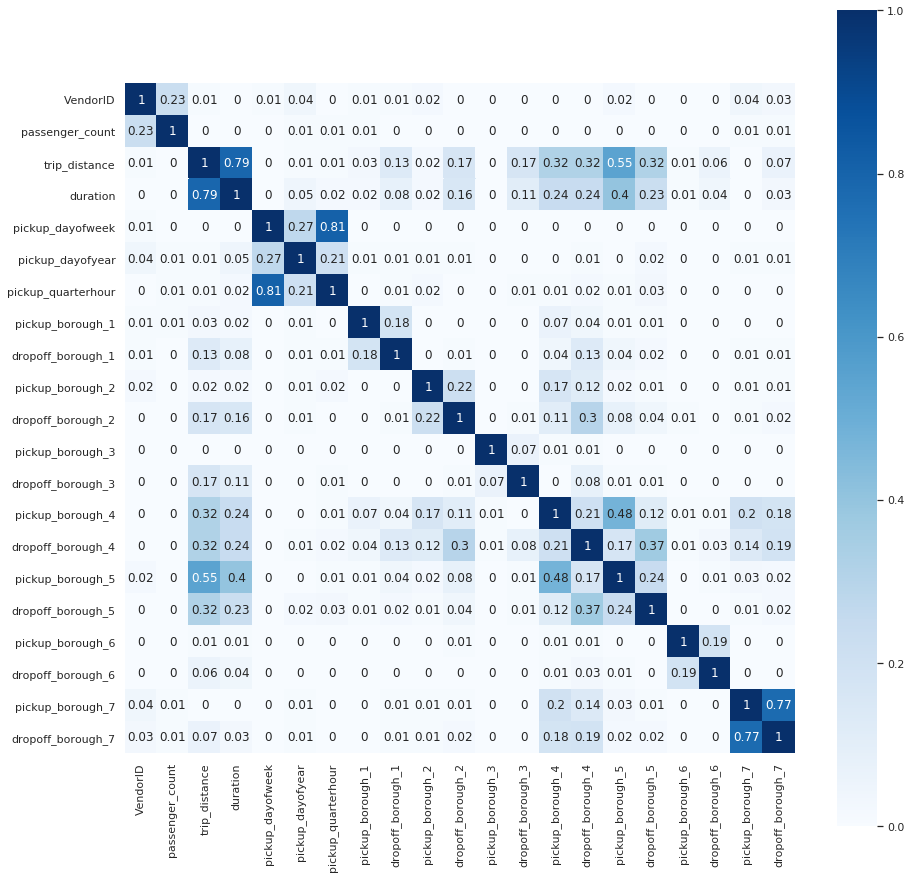

In [19]:
plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(np.round(train.corr(), 2)), square=True, annot=True, cmap=plt.cm.Blues)
plt.show()

Of course, we note a high correlation between `trip_distance` and `duration`.

# 4. Modeling

## 4.1. Data Splitting

It's time to build some models ! Here we simply create the train, validation and test sets. 

In [20]:
X, y = train.drop(columns=["duration"]), train["duration"]
X_test = test

validate = True

if validate:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

## 4.2. Regressors

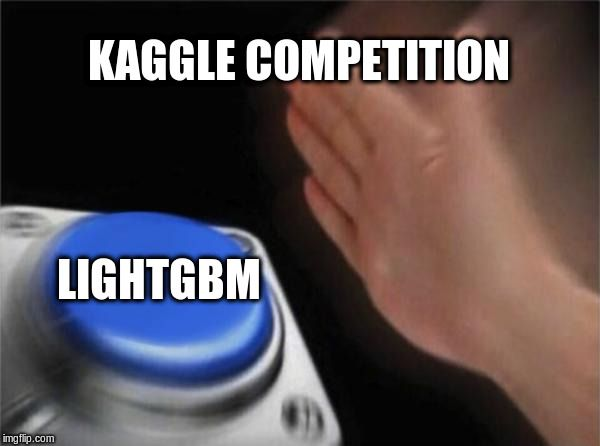 <br>

Of course, we use gradient boosted trees! From the experiments I did, `lightgbm` seems to give better results than `xgboost` on this dataset. We first tune `n_estimators` and `num_leaves` on a single LightGBM regressor to get the best possible result on the validation set, and we then use ensembling of LightGBM regressors through a voting classifier, building a smart mix of many shallow trees and few deep trees.

We then perform some fine-tuning of other parameters to improve the performance. We first decrease the `learning_rate` and increase `n_estimators`, and finally tune `reg_lambda` and `colsample_bytree`.

In [21]:
commargs = {"learning_rate": 0.03, "colsample_bytree": 0.9, "reg_lambda": 0.2, "random_state": seed, "n_jobs": -1}

lgbm_63 = LGBMRegressor(n_estimators=12000, num_leaves=63, **commargs)
lgbm_127 = LGBMRegressor(n_estimators=6000, num_leaves=127, **commargs)
lgbm_255 = LGBMRegressor(n_estimators=4000, num_leaves=255, **commargs)
lgbm_511 = LGBMRegressor(n_estimators=2000, num_leaves=511, **commargs)
lgbm_1023 = LGBMRegressor(n_estimators=1000, num_leaves=1023, **commargs)

lgbm_estimators = [
    ("LGBM_63", lgbm_63), ("LGBM_127", lgbm_127), ("LGBM_255", lgbm_255),
    ("LGBM_511", lgbm_511), ("LGBM_1023", lgbm_1023),
]

lgbm_voting = VotingRegressor(lgbm_estimators)

## 4.3. Validation

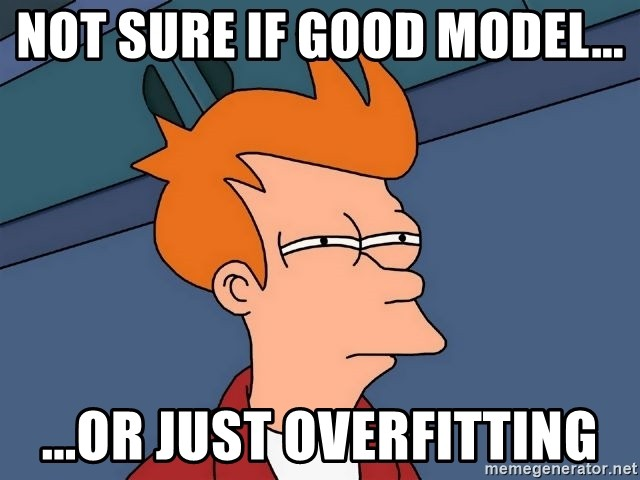 <br>

We display the performance of our estimators on the validation set *only on trips lasting less than approximately 2 hours*, as very few outliers are remaining in our training data, and taking the risk to have a bad performance on outliers of the test set. We also use Root Mean Squared Logarithmic Error (RMSLE) in addition to RMSE to evaluate the performance.

Fortunately, we note that the performance of the voting classifier based on our 5 LightGBM regressors is better than all of the regressors taken individually.

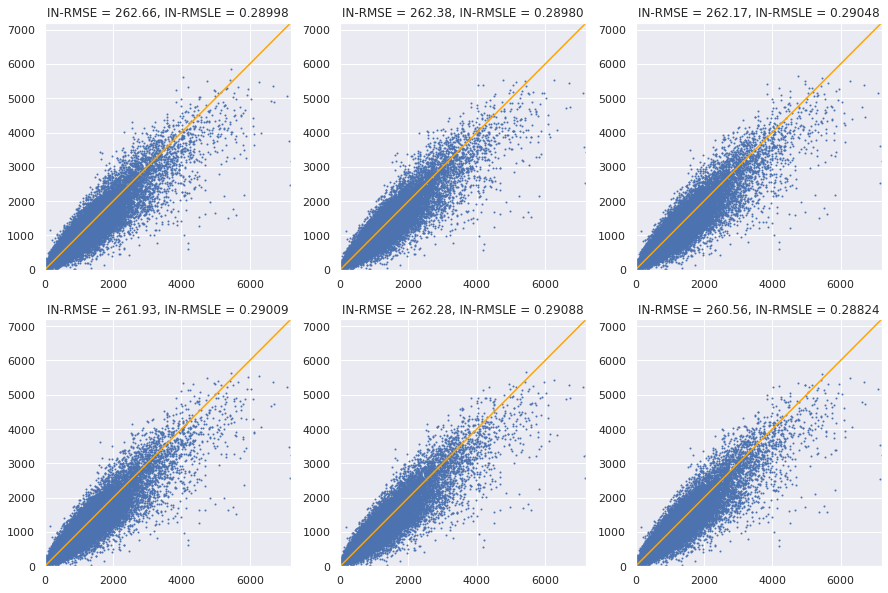

In [22]:
def plot_classifiers_validation(regs, X_train, y_train, X_val, y_val):
    fitted_regs = []
    nb_rows, nb_cols = 2, 3
    fig, ax = plt.subplots(figsize=(15, 10), nrows=nb_rows, ncols=nb_cols)
    for ind, reg in enumerate(regs):
        reg.fit(X_train, np.log(y_train))
        fitted_regs.append(reg)
        y_pred = reg.predict(X_val)
        ax[ind // nb_cols, ind % nb_cols].scatter(y_val, np.exp(y_pred), s=1)
        max_plot_value = max(y_val.max(), np.exp(y_pred).max())
        ax[ind // nb_cols, ind % nb_cols].plot([0, max_plot_value], [0, max_plot_value], color="orange")
        ax[ind // nb_cols, ind % nb_cols].set_title("IN-RMSE = {0:.2f}, IN-RMSLE = {1:.5f}".format(
            np.sqrt(mean_squared_error(y_val[y_val <= 7000], np.exp(y_pred)[y_val <= 7000])),
            np.sqrt(mean_squared_log_error(y_val[y_val <= 7000], np.exp(y_pred)[y_val <= 7000]))
        ))
        ax[ind // nb_cols, ind % nb_cols].set_xlim(0, max_plot_value)
        ax[ind // nb_cols, ind % nb_cols].set_ylim(0, max_plot_value)
    plt.show()
    return fitted_regs


if validate:
    lgbm_regs = plot_classifiers_validation(
        [lgbm_63, lgbm_127, lgbm_255, lgbm_511, lgbm_1023, lgbm_voting], X_train, y_train, X_val, y_val
    )

## 4.4. Feature Importances

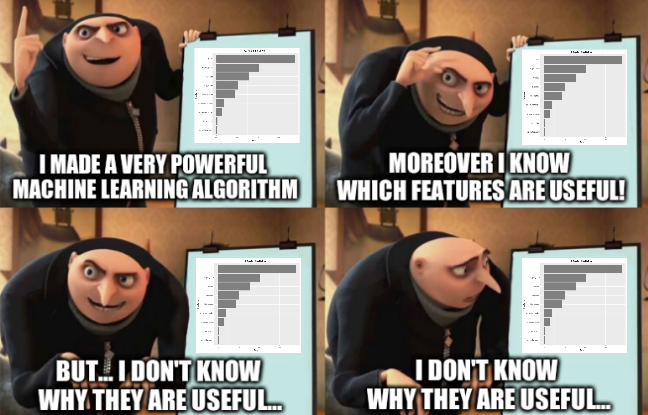 <br>

We mainly use feature importances for feature selection and building the model. On this final model with only 8 main features, we note that `trip_distance`, `pickup_dayofyear` and `pickup_quarterhour` are the most important features, with an importance of around 20% for each. We note that the importance of the least important feature, `VendorID`, is around 2%, which is only 10 times less than the most important one, meaning that we do not have a feature very insignificant compared to others.

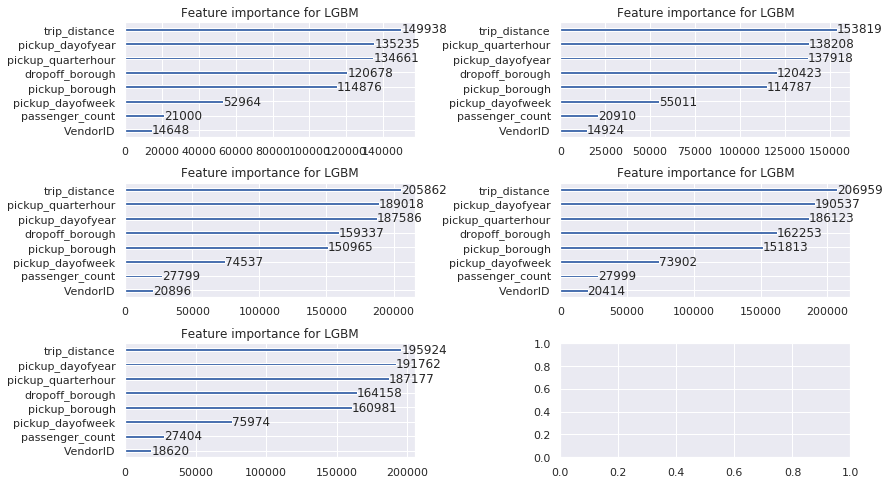

In [23]:
categorical_columns = ["VendorID", "passenger_count", "pickup_dayofweek", "pickup_borough", "dropoff_borough"]
numerical_columns = ["trip_distance", "pickup_dayofyear", "pickup_quarterhour"]


def plot_lgbm_feature_importance(clf, ax):
    ft_imp_dummies = dict(zip(X_train.columns, clf.feature_importances_))
    ft_imp = {
        column: sum([value for key, value in ft_imp_dummies.items() if column in key])
        if column in categorical_columns else ft_imp_dummies[column]
        for column in categorical_columns + numerical_columns
    }
    ft_imp = {key: value for key, value in sorted(ft_imp.items(), key=lambda item: item[1])}

    labels, values = list(ft_imp.keys()), list(ft_imp.values())
    ylocs = np.arange(len(values))
    ax.barh(ylocs, values, align='center', height=0.2)
    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, x, va='center')
    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)
    ax.set_title("Feature importance for LGBM")


if validate:
    fig, ax = plt.subplots(figsize=(13, 8), nrows=3, ncols=2)
    for ind, reg in enumerate(lgbm_regs[:-1]):
        plot_lgbm_feature_importance(reg, ax=ax[ind // 2, ind % 2])
    plt.subplots_adjust(wspace=0.5, hspace=0.4)
    plt.show()

## 5. Prediction

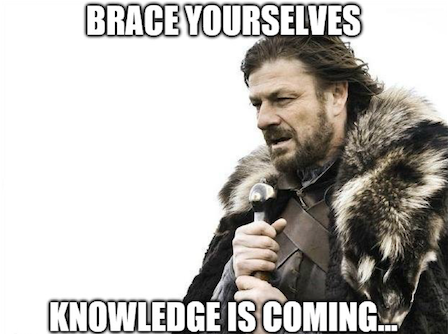 <br>

We are already at this end of this kernel! We just have to train our voting classifier model on all the training data to have our predictions!

Train RMSE:  190.49726674970003


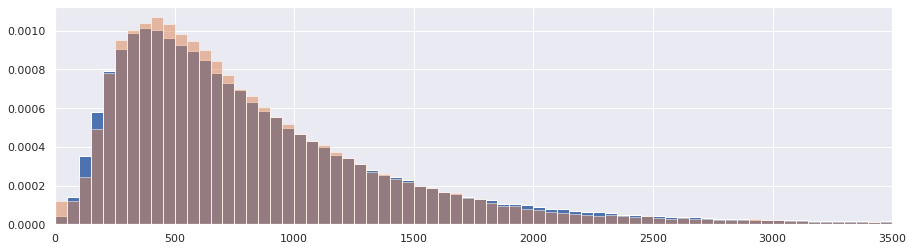

row_id     duration
0           0   328.117037
1           1   930.681444
2           2  1368.281797
3           3   313.750679
4           4  2734.900699
...       ...          ...
79388   79388  1235.777996
79389   79389   922.813480
79390   79390   903.977911
79391   79391   799.878674
79392   79392   302.987987

[79393 rows x 2 columns]

In [24]:
fit_predict = True
predict_on_train = True

if fit_predict:
    plt.figure(figsize=(15, 4))
    lgbm_voting.fit(X, np.log(y))

    if predict_on_train:
        y_pred = np.exp(lgbm_voting.predict(X))
        print("Train RMSE: ", np.sqrt(mean_squared_error(y, y_pred)))
        plt.hist(y, density=True, bins=[50 * i for i in range(160)])

    y_sub = np.exp(lgbm_voting.predict(X_test))
    plt.hist(y_sub, density=True, bins=[50 * i for i in range(160)], alpha=0.5)
    plt.xlim((0, 3500))
    plt.show()

    sub["duration"] = y_sub
    display(sub)
    sub.to_csv("lgbm-voting-final.csv", index=False)

We check that the train RMSE is not too far from the validation RMSE to avoid overfitting. Moreover, the distribution of predictions on the test data is the same as the distribution for predictions on train data, confirming there are few chances of overfitting.

Public score for this model is 258.47466, which is almost the validation RMSE for the voting classifier, showing again that the model clearly does not overfit and learned a bit more by training on 25% more data. The private score is 253.84098, confirming again the absence of overfitting.

**Many thanks to the UC Berkeley IEOR 242 Spring 2020 team (Prof. George Ng and GSIs Peijie Li & Yunduan Lin) for the organization of this competition!**